# 개요
## 목적: 독립변수들을 이용하여 종속변수인 따릉이 이용량을 예측하는 모델구성
## 진행순서
- 데이터 변수분석
- 가설설정 및 시각화
- 결측치 및 이상치 보완
- 범주형변수 처리
- 최종변수 처리 (다중공선성 및 스케일링)
- 예측모델 학습
- 모델 성능 비교 및 해석

### 1. 데이터 변수 분석

In [64]:
# 데이터 불러와 확인
import pandas as pd
df=pd.read_csv("C:/Users/qkrrl/python/train.csv")
print(df.head(10))

         Date  Rented Bike Count  Hour  Temperature(째C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   
5  01/12/2017                100     5             -6.4           37   
6  01/12/2017                181     6              NaN           35   
7  01/12/2017                460     7             -7.4           38   
8  01/12/2017                930     8              NaN           37   
9  01/12/2017                490     9             -6.5           27   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(째C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2  

In [65]:
# 변수확인
print(df.columns)

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(째C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


In [66]:
# 변수 기초통계량 확인
print(df.select_dtypes(include=['number']).mean())

Rented Bike Count             709.775995
Hour                           11.500000
Temperature(째C)                13.498564
Humidity(%)                    58.271020
Wind speed (m/s)                1.756756
Visibility (10m)             1459.170896
Dew point temperature(째C)       4.522239
Solar Radiation (MJ/m2)         0.587072
Rainfall(mm)                    0.152164
Snowfall (cm)                   0.066493
dtype: float64


In [67]:
# 기초통계량 요약
print(df.describe())

       Rented Bike Count         Hour  Temperature(째C)  Humidity(%)  \
count        8040.000000  8040.000000      7240.000000  8040.000000   
mean          709.775995    11.500000        13.498564    58.271020   
std           657.320605     6.922617        12.270471    20.340492   
min             0.000000     0.000000       -17.800000     0.000000   
25%           191.000000     5.750000         3.500000    43.000000   
50%           485.000000    11.500000        15.600000    57.000000   
75%          1080.500000    17.250000        23.300000    74.000000   
max          3556.000000    23.000000        39.400000    98.000000   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature(째C)  \
count       7238.000000       8040.000000                8040.000000   
mean           1.756756       1459.170896                   4.522239   
std            1.045901        603.716284                  13.393517   
min            0.000000         27.000000                 -30.600000   


### 2. 변수에 대한 가설설정 및 시각화

##### 가설
- Temperature , Solar Radiation : 양의 상관관계 (햇빛과 기온)
- Dew poin Temp , Humidity : 양의 상관관계 (이슬점과 습도)
- Rainfall , Humidity: 양의 상관 (비와 습도상승)
- Hour , Solar Radiation: 일몰 일출
- Hour, Temperature: 일간 기온변화
- Solar Radiation , Snowfall/Rainfall: 음의 상관관계

c:\Users\qkrrl\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


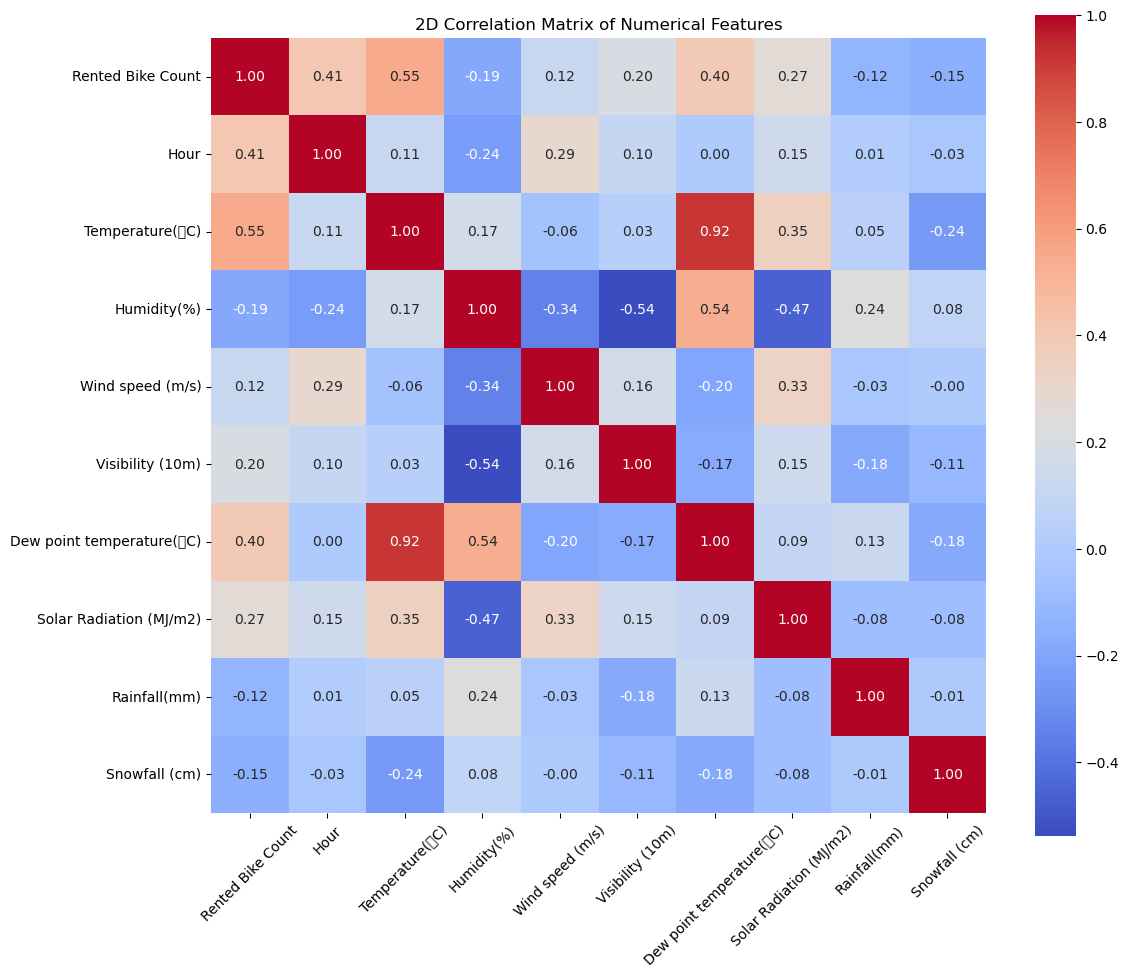

In [68]:
# 상관관계 히트맵
import seaborn as sns
import matplotlib.pyplot as plt
exclude_cols = ['Seasons', 'Holiday', 'Functioning Day', 'Date', 'Datetime']
corr_df = df.drop(columns=exclude_cols, errors='ignore').select_dtypes(include='number')
corr_matrix = corr_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('2D Correlation Matrix of Numerical Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 결론: Dew point temperature 과 Temperature는 강한 양의 상관관계가 존재하며 나머지 유의미하게 큰 상관관계는 없어보임

### 3. 결측치 및 이상치보완

In [69]:
# 결측치 확인
print((df.isna().sum()))

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(째C)              800
Humidity(%)                    0
Wind speed (m/s)             802
Visibility (10m)               0
Dew point temperature(째C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      802
Holiday                        0
Functioning Day                0
dtype: int64


#### 문자형 결측치 보완

In [70]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# 함수 정의: 특정 날짜 범위에 따라 계절 반환
def infer_season(date):
    if pd.Timestamp('2018-03-01') <= date <= pd.Timestamp('2018-05-31'):
        return 'Spring'
    elif pd.Timestamp('2018-06-01') <= date <= pd.Timestamp('2018-08-31'):
        return 'Summer'
    elif pd.Timestamp('2018-09-01') <= date <= pd.Timestamp('2018-10-31'):
        return 'Autumn'
    else:
        return 'Winter'


# 결측치인 경우만 날짜 기반으로 채우기
df['Seasons'] = df['Seasons'].fillna(df['Date'].apply(infer_season))

#### 보간법활용, 결측치 보완
- 결측값의 양쪽에 있는 값들을 직선으로 연결해 그 사이의 값을 계산하는 방식

In [71]:
# 날짜와 시간 기반으로 정렬
df['Datetime'] = df['Date'] + pd.to_timedelta(df['Hour'], unit='h')
df = df.sort_values('Datetime')

In [72]:
# 결측치 채우기
df['Temperature(째C)'] = df['Temperature(째C)'].interpolate(method='linear')
df['Wind speed (m/s)'] = df['Wind speed (m/s)'].interpolate(method='linear')


In [73]:
# 결측치 남은 것 확인
print(df.isna().sum())

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(째C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(째C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Datetime                     0
dtype: int64


C:\Users\qkrrl\AppData\Local\Temp\ipykernel_35292\325276451.py:17: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


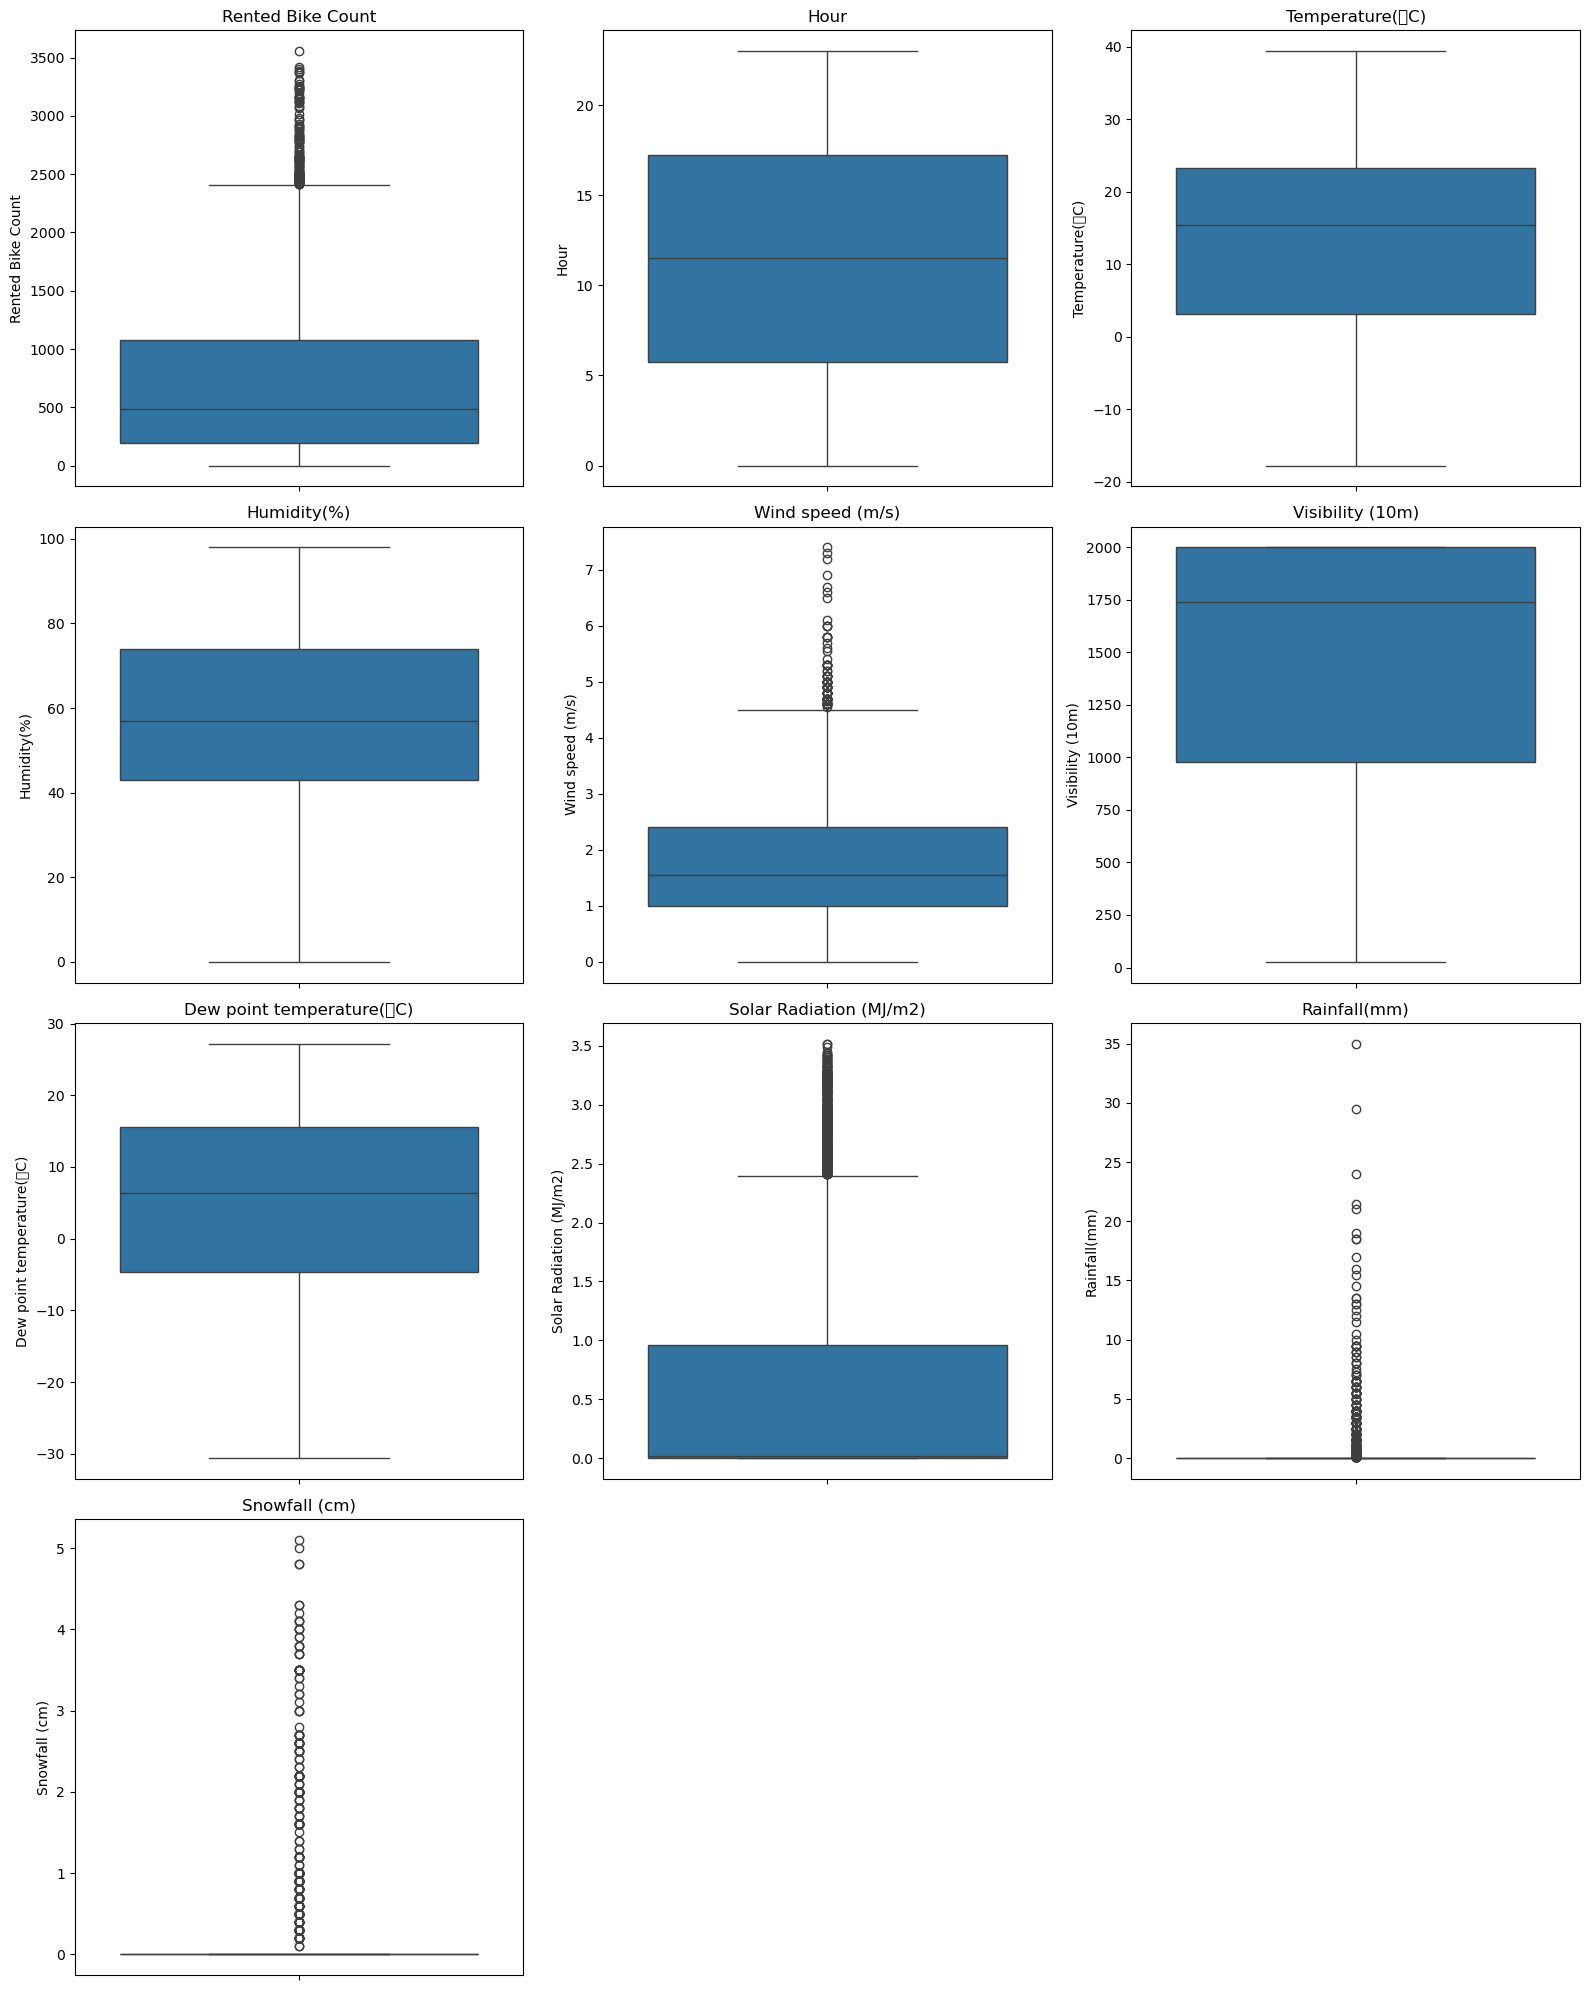

In [74]:
# 데이터 시각화
import math
import seaborn as sns

# 수치형 변수
num_df=df.select_dtypes(include=['number'])
num_cols = len(num_df.columns)
rows = math.ceil(num_cols / 3)  # 3열씩 배치하기 위한 행 수 계산

# 시각화 실행
plt.figure(figsize=(16, 5 * rows))
for i, column in enumerate(num_df.columns, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(y=num_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

- 시각화결과 : 크게 벗어나는 값은 없는 것으로 확인됨 즉, 이상치 처리는 할 필요없음

### 4. 범주형 변수 처리

- Holiday , Functioning day: 이진형이므로 더미변수화
- Seasons: 0,1,2,3를 각각 봄, 여름, 가을, 겨울로 변수화

In [75]:
# 변수들 확인
print(df.columns)

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(째C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Datetime'],
      dtype='object')


#### 더미변수화

In [76]:
# 1. Seasons: 문자열 -> 숫자
season_map = {'Spring': 0, 'Summer': 1, 'Autumn': 2,'Winter':3}
df['Seasons'] = df['Seasons'].astype(str).str.strip()  # 문자열 정리
df['Seasons'] = df['Seasons'].map(season_map)

In [77]:
# 2. Holiday: 더미변수화
df['Holiday'] = df['Holiday'].astype(str).str.strip()
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0, 'Holiday': 1, 'No Holiday': 0})

In [78]:
# 3. Functioning Day: 더미변수화
df['Functioning Day'] = df['Functioning Day'].astype(str).str.strip()
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

In [79]:
# 확인
print(df[['Holiday','Functioning Day','Seasons']].head(10))

   Holiday  Functioning Day  Seasons
0        0                1        3
1        0                1        3
2        0                1        3
3        0                1        3
4        0                1        3
5        0                1        3
6        0                1        3
7        0                1        3
8        0                1        3
9        0                1        3


### 5. 스케일링 및 다중공선성 문제 해결
- 학습시킬 모델이 회귀모형이므로 표준화 방식으로 스케일링
- 히트맵에서 나온 두 변수(Dew point temperature, Temperature)의 다중공선성 문제 완화

In [ ]:
#스케일링
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 제외할 열들
exclude_cols = ['Date', 'Datetime', 'Seasons', 'Holiday', 'Functioning Day', 'Rented Bike Count']

# 수치형 변수만 선택 (제외 열을 제거하고)
X = df.drop(columns=exclude_cols, errors='ignore').select_dtypes(include='number')

# 표준 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 결과를 DataFrame으로 변환
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 결과 미리보기
print(X_scaled_df.head())

       Hour  Temperature(째C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0 -1.661325        -1.508550    -1.045813          0.432601          0.895889   
1 -1.516862        -1.532961    -0.996647         -0.917655          0.895889   
2 -1.372399        -1.573646    -0.947480         -0.724761          0.895889   
3 -1.227936        -1.589921    -0.898314         -0.821208          0.895889   
4 -1.083473        -1.573646    -1.094979         -0.531867          0.895889   

   Dew point temperature(째C)  Solar Radiation (MJ/m2)  Rainfall(mm)  \
0                  -1.651815                -0.662512     -0.135022   
1                  -1.651815                -0.662512     -0.135022   
2                  -1.659282                -0.662512     -0.135022   
3                  -1.651815                -0.662512     -0.135022   
4                  -1.726483                -0.662512     -0.135022   

   Snowfall (cm)  
0      -0.175832  
1      -0.175832  
2      -0.175832  
3      -0.

C:\Users\qkrrl\AppData\Local\Temp\ipykernel_35292\1412803667.py:20: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\qkrrl\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


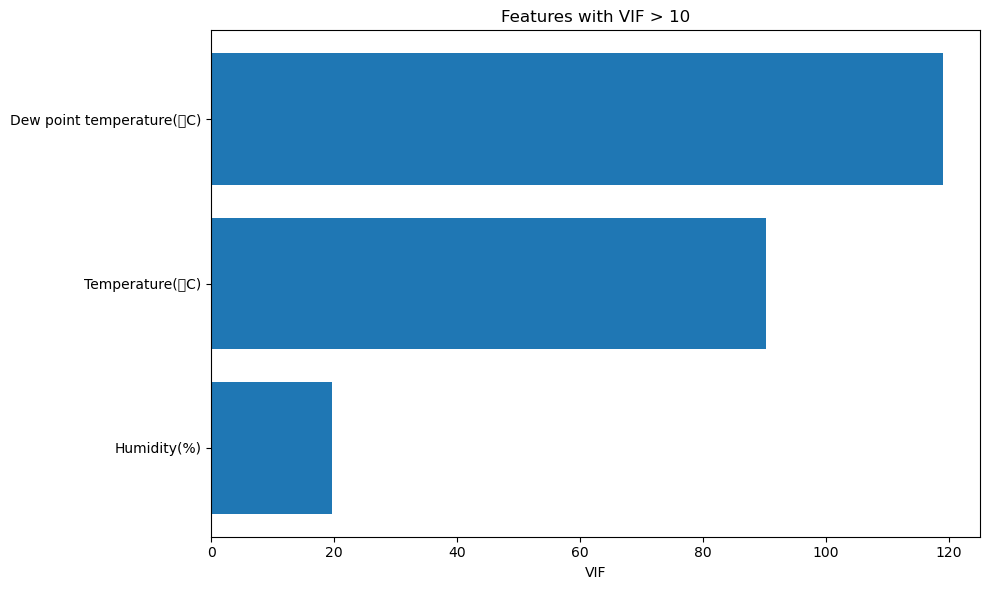

,Feature,VIF
5,Dew point temperature(째C),119.156661
1,Temperature(째C),90.350819
2,Humidity(%),19.698277
6,Solar Radiation (MJ/m2),2.031466
4,Visibility (10m),1.551542
3,Wind speed (m/s),1.287414
0,Hour,1.180652
8,Snowfall (cm),1.094729
7,Rainfall(mm),1.087846


In [81]:
# 다중공선성 변수 탐지
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 수치형 변수
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['Feature'] = X_scaled_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

# VIF > 10 시각화
high_vif = vif_data[vif_data['VIF'] > 10].sort_values(by='VIF', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(high_vif['Feature'], high_vif['VIF'])
plt.xlabel('VIF')
plt.title('Features with VIF > 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

vif_data.sort_values(by='VIF', ascending=False)

#### 결과 해석
- Temperature, Dew point temperature -> VIF 문제
- 삭제 또는 PCA 방법 생각해볼 수 있음 -> 해석가능성과 예측모델의 성능 모두 고려
- Humidex=T+0.5555×(6.11×e^5417.7530×(1/273.16-1/ 273.15+Td)−10) 라는 식이 존재 즉, 기온과 이슬점의 관계식 존재 -> '체감온도' 변수 생성가능
- 결론: 두 변수를 합쳐 체감온도 변수 추가 후, 나머지 변수들 삭제 -> 다중공선성 문제해결 및 해석가능성까지 보장

In [82]:
import numpy as np

# Humidex 계산 함수
def calculate_humidex(T, Td):
    e = 6.11 * np.exp(5417.7530 * ((1/273.16) - (1 / (273.15 + Td))))
    h = T + 0.5555 * (e - 10)
    return h

# Humidex 계산
df['Humidex'] = calculate_humidex(df['Temperature(째C)'], df['Dew point temperature(째C)'])

# 원래 변수 제거
df = df.drop(columns=['Temperature(째C)', 'Dew point temperature(째C)'])


# Humidex 변수 자체를 스케일링하여 덮어쓰기
df['Humidex'] = scaler.fit_transform(df[['Humidex']])

# 결과 확인
print(df[['Humidex']].head())

    Humidex
0 -1.454159
1 -1.472210
2 -1.502726
3 -1.514329
4 -1.506456


#### test 데이터도 동일하게 전처리

In [105]:
import pandas as pd
test_df=pd.read_csv("C:/Users/qkrrl/python/test.csv")

In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: 날짜 변환 및 계절 채우기
test_df['Date'] = pd.to_datetime(test_df['Date'], dayfirst=True)

def infer_season(date):
    if pd.Timestamp('2018-03-01') <= date <= pd.Timestamp('2018-05-31'):
        return 'Spring'
    elif pd.Timestamp('2018-06-01') <= date <= pd.Timestamp('2018-08-31'):
        return 'Summer'
    elif pd.Timestamp('2018-09-01') <= date <= pd.Timestamp('2018-10-31'):
        return 'Autumn'
    else:
        return 'Winter'

test_df['Seasons'] = test_df['Seasons'].fillna(test_df['Date'].apply(infer_season))

# Step 2: 보간법 및 정렬
test_df['Datetime'] = test_df['Date'] + pd.to_timedelta(test_df['Hour'], unit='h')
test_df = test_df.sort_values('Datetime')
test_df['Temperature(째C)'] = test_df['Temperature(째C)'].interpolate(method='linear')
test_df['Wind speed (m/s)'] = test_df['Wind speed (m/s)'].interpolate(method='linear')

# Step 3: 더미변수화
season_map = {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}
test_df['Seasons'] = test_df['Seasons'].astype(str).str.strip().map(season_map)

test_df['Holiday'] = test_df['Holiday'].astype(str).str.strip().map({'Yes': 1, 'No': 0, 'Holiday': 1, 'No Holiday': 0})
test_df['Functioning Day'] = test_df['Functioning Day'].astype(str).str.strip().map({'Yes': 1, 'No': 0})

# Step 4: 스케일링
exclude_cols = ['Date', 'Datetime', 'Seasons', 'Holiday', 'Functioning Day']
X_test = test_df.drop(columns=exclude_cols, errors='ignore').select_dtypes(include='number')

scaler = StandardScaler()
X_scaled_test = scaler.fit_transform(X_test)
X_scaled_df_test = pd.DataFrame(X_scaled_test, columns=X_test.columns)

# Step 5: Humidex 계산 및 스케일링
def calculate_humidex(T, Td):
    e = 6.11 * np.exp(5417.7530 * ((1/273.16) - (1 / (273.15 + Td))))
    h = T + 0.5555 * (e - 10)
    return h

test_df['Humidex'] = calculate_humidex(test_df['Temperature(째C)'], test_df['Dew point temperature(째C)'])
test_df = test_df.drop(columns=['Temperature(째C)', 'Dew point temperature(째C)'])
test_df['Humidex'] = scaler.fit_transform(test_df[['Humidex']])

print(test_df.head())


        Date  Hour  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0 2018-11-01     0           62              2.30              1909   
1 2018-11-01     1           65              1.60              1932   
2 2018-11-01     2           64              1.15              2000   
3 2018-11-01     3           65              0.70              1962   
4 2018-11-01     4           70              0.80              1934   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  \
0                      0.0           0.0            0.0        2        0   
1                      0.0           0.0            0.0        2        0   
2                      0.0           0.0            0.0        2        0   
3                      0.0           0.0            0.0        2        0   
4                      0.0           0.0            0.0        2        0   

   Functioning Day            Datetime   Humidex  
0                1 2018-11-01 00:00:00 -0.440525  
1       

### 6. 예측모델 학습
- 다항회귀 : Full 모델
- Lasso (L1) 

In [111]:
# 타겟 변수
y = df['Rented Bike Count']

# 특성 변수: 이미 스케일링한 X_scaled_df + df['Humidex']
X_scaled_df['Humidex'] = df['Humidex'].values

# 더미 처리된 범주형 변수도 포함
X_scaled_df['Seasons'] = df['Seasons'].values
X_scaled_df['Holiday'] = df['Holiday'].values
X_scaled_df['Functioning Day'] = df['Functioning Day'].values

#### 다항회귀모델 성능검증
- 다항회귀모델은 Full model 즉, 모든 변수,변수^2,interation포함한것

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 학습/검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

# 다항 특성 생성
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# 회귀 모델 학습
model = LinearRegression()
model.fit(X_train_poly, y_train)

# 예측 및 평가
y_pred = model.predict(X_val_poly)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.730
MAE: 242.27
RMSE: 344.05


- 평가: 0.7의 설명력으로 괜찮은 수준으로 판단됨

#### test 데이터 활용하여 예측

In [ ]:
# 앞에서 스케일링된 수치형 변수만 있는 X_scaled_df_test에 나머지 변수들 붙이기
X_scaled_df_test['Humidex'] = test_df['Humidex'].values
X_scaled_df_test['Seasons'] = test_df['Seasons'].values
X_scaled_df_test['Holiday'] = test_df['Holiday'].values
X_scaled_df_test['Functioning Day'] = test_df['Functioning Day'].values

In [114]:
# train에서 활용한 것 그대로 활용
X_test_poly = poly.transform(X_scaled_df_test)

In [ ]:
# 예측수행 및 결과확인 (시간과 예측량으로 구성)
y_test_pred = model.predict(X_test_poly)
test_df['Predicted Count'] = y_test_pred
print(test_df[['Date', 'Hour', 'Predicted Count']].head())

        Date  Hour  Predicted Count
0 2018-11-01     0       529.961344
1 2018-11-01     1       150.768610
2 2018-11-01     2      -431.703563
3 2018-11-01     3      -542.985735
4 2018-11-01     4      -999.330786


#### Lasso(L1)모델

In [119]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항 특성 생성 (이미 스케일된 X_train, X_val이 있다고 가정)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Lasso 모델 학습 (교차 검증 기반 alpha 자동 선택)
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_poly, y_train)

# 예측
y_val_pred = lasso.predict(X_val_poly)

# 평가 지표 출력
r2 = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))


print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R² Score: 0.727
MAE: 244.39
RMSE: 345.92


- 평가: 다항회귀(2차)FUll model과 설명력, 오차 모두 비슷